# 3. VIENNA dataset, classification and regression, first look

- try different prediction models for both binary classification (HVPG >= 16?) and regression (predict numerical value of HVPG)
- no systematic evaluation of models at this stage, just split the dataset into training and test sets once and see the results:
    - confusion matrix (binary classification)
    - r2 score (regression)
    
<sub>original notebook name: `VICIS_03_HVPG_prediction_all_markers_first_look.ipynb`</sub>

In [1]:
import numpy as np                                                     # numerical computing tools
import pandas as pd                                                    # data science library

import seaborn as sns                                                  # visualizations
import matplotlib.pyplot as plt                                        # visualizations
from IPython.display import set_matplotlib_formats

from sklearn.preprocessing import StandardScaler, LabelBinarizer       # scaling, encoding binary label
from sklearn.model_selection import train_test_split                   # train-test split

# prediction models
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

# set a nice theme for plots
sns.set_context(context='talk')

### Load preprocessed dataset (missing data imputed with kNN)

In [2]:
data = pd.read_pickle("../preprocessed/VICIS_CeMM_preprocessed_v3_kNN_imputed.pickle").reset_index()

### Extract predictor variables

- For now, etiology not included in any form

In [ ]:
# extract predictor variables
X = data.iloc[:, 13:]

display(X)

### Scale predictor variables

In [77]:
# initialize rescaler for k-NN
scaler = StandardScaler()

# rescale to standard score
X_scaled = pd.DataFrame(scaler.fit_transform(X))

## Binary classification: predict elevated vs. high-risk

### Split data into training set and test set

In [78]:
# extract target variable
y = data["HVPG_label_code"]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

### Evaluation: confusion matrix

In [79]:
def plot_cf_matrix(y_test, y_pred, title="Confusion matrix"):
    
    cf_matrix = confusion_matrix(y_test, y_pred)
    counts = cf_matrix.flatten()
    fields = ["True Negative","False Positive","False Negative","True Positive"]
    ticks = ["Low-risk", "High-risk"]
    
    # merge field labels with the corresponding numbers
    labels = np.asarray(["{}\n{}".format(x[0], x[1]) for x in zip(fields, counts)]).reshape(2,2)
    
    # print(labels)
    
    # plot settings
    %matplotlib inline
    set_matplotlib_formats('retina')
    sns.set(font_scale=.98)
    fig = plt.figure(figsize=(3,3), dpi= 100)

    # plot
    sns.heatmap(cf_matrix,
                annot=labels, fmt='', xticklabels=ticks, yticklabels=ticks,
                cmap="Blues", cbar=False,)

    # set labels and title
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title, fontweight="bold")
    
    plt.show()

### Logistic regression

In [80]:
# fit the model to training data
clf = LogisticRegression(C = 0.2).fit(X_train, y_train)
# predict
result = pd.DataFrame(y_test)
result["prediction"] = clf.predict(X_test)

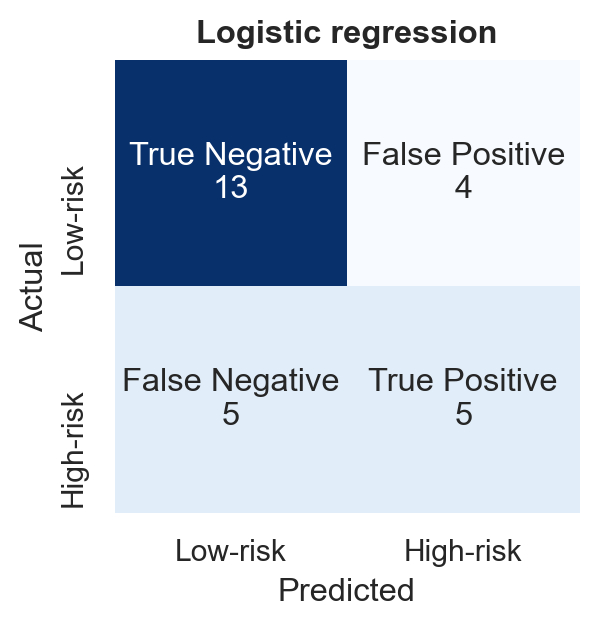

In [81]:
plot_cf_matrix(y_test, clf.predict(X_test), "Logistic regression")

### Neural network

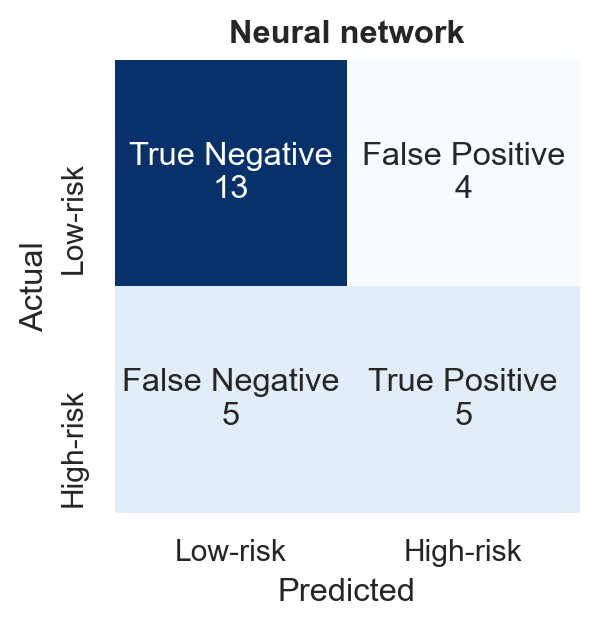

In [83]:
# fit the model to training data
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1500, warm_start=True, alpha=.1).fit(X_train, y_train)
title = "Neural network"

plot_cf_matrix(y_test=y_test, y_pred = clf.predict(X_test), title = "Neural network")

### SVM

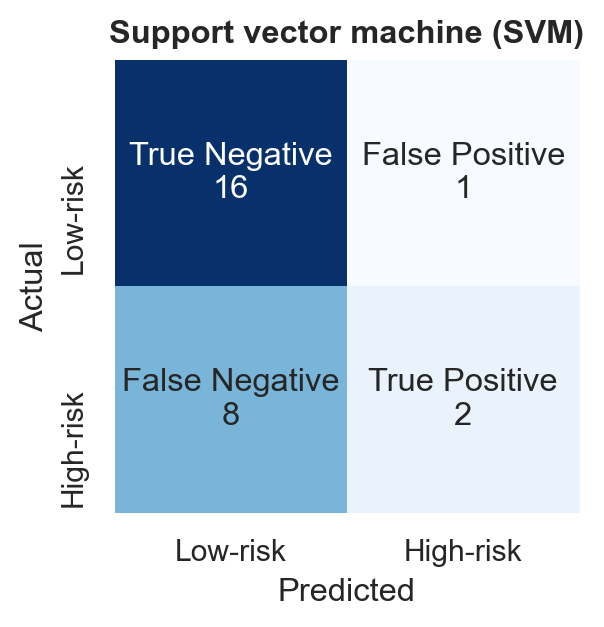

In [84]:
# fit the model to training data
clf = SVC(kernel='rbf', C = 0.8).fit(X_train, y_train)
title = "SVM (support vector machine)"

plot_cf_matrix(y_test=y_test, y_pred = clf.predict(X_test), title = "Support vector machine (SVM)")

### Random forest

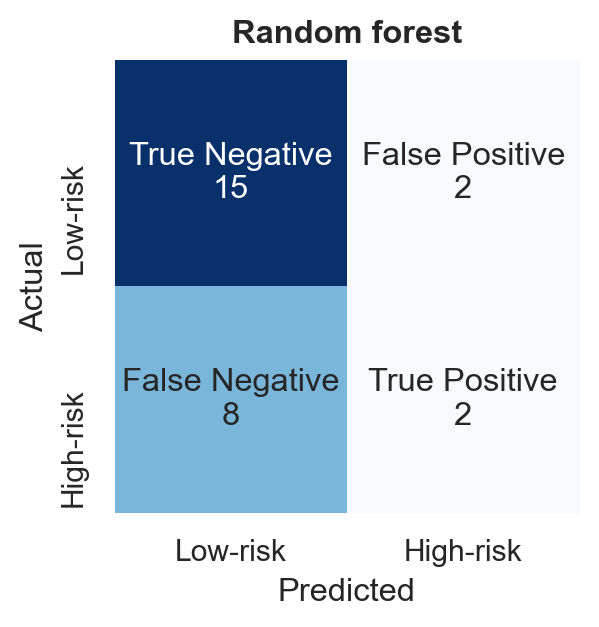

In [85]:
clf = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
title = "Random forest"

plot_cf_matrix(y_test=y_test, y_pred = clf.predict(X_test), title = "Random forest")

### Extreme Gradient Boosting

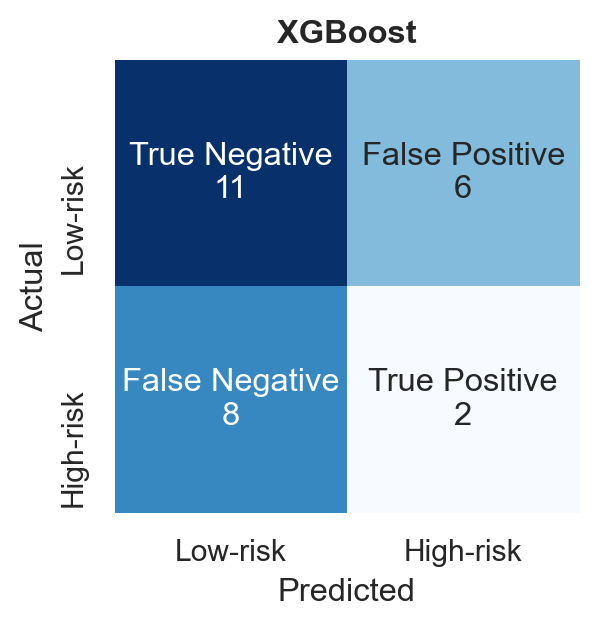

In [86]:
clf = XGBClassifier(n_estimators = 100).fit(X_train, y_train)
title = "XGBoost (Extreme Gradient Boosting)"

plot_cf_matrix(y_test=y_test, y_pred = clf.predict(X_test), title = "XGBoost")

### k-NN classifier

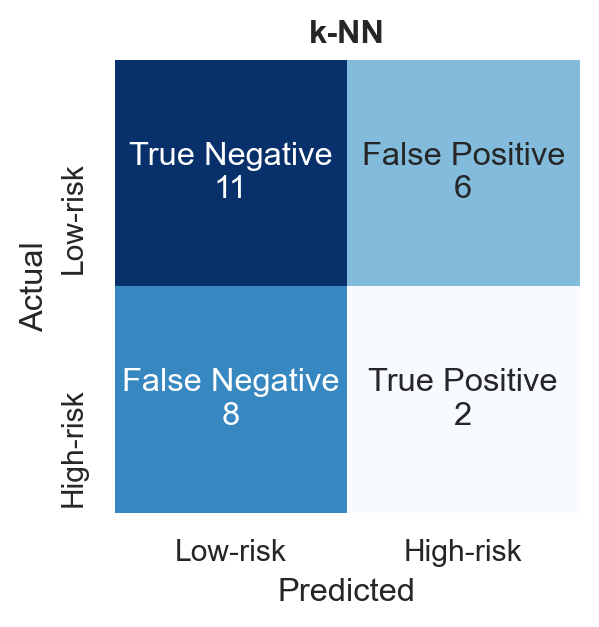

In [87]:
# clf = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
title = "k-NN (k = 3)"

plot_cf_matrix(y_test=y_test, y_pred = clf.predict(X_test), title = "k-NN")

## Regression: predict HVPG (numeric value) using different models

In [88]:
y = data["HVPG"]

### Split data into training set and test set

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Evaluation: r2 score, scatterplot

In [53]:
def eval_regression(y_test, y_pred, title=""):
    # r2 score
    r2 = r2_score(y_test, y_pred)
    print("r2 score: {:.3f}".format(r2))
    plt.figure(figsize=(6,3.6), dpi = 50)
    
    sns.set_context(context="notebook", font_scale=1.4)
    
    # scatterplot of prediction
    g = sns.scatterplot(x = y_test, y = y_pred)
    g.axhline(16, ls = "--", color = "r", lw = .75) 
    g.axvline(16, ls = "--", color = "r", lw = .75)
    g.axline((0, 0), (1, 1), ls = "-", color = "black", lw = .75, alpha = .3)
   
    g.set(xlim = (4,24),
          ylim = (4,25),
          xticks = np.arange(4,24.05, 2),
          yticks = np.arange(4,24.05, 2),
         )

    plt.ylabel('Predicted HVPG')
    plt.title(title+f" ($r^2$ = {r2:.3f})",fontweight="bold")
    plt.show()
    return r2

### Linear regression

In [50]:
r2 = dict()

In [51]:
set_matplotlib_formats('retina')

r2 score: -4.493


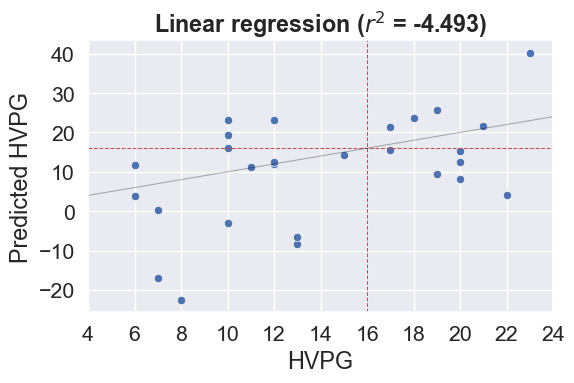

In [52]:
name = "Linear regression"
reg = LinearRegression().fit(X_train, y_train)

# evaluate
r2[name] = eval_regression(y_test, reg.predict(X_test), name)

### Ridge regression

r2 score: 0.527


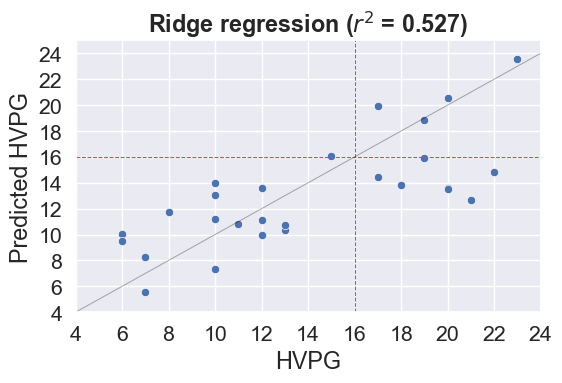

In [54]:
name = "Ridge regression"
reg = Ridge(alpha=50).fit(X_train, y_train)

r2[name] = eval_regression(y_test, reg.predict(X_test), name)

### Lasso regression

r2 score: 0.487


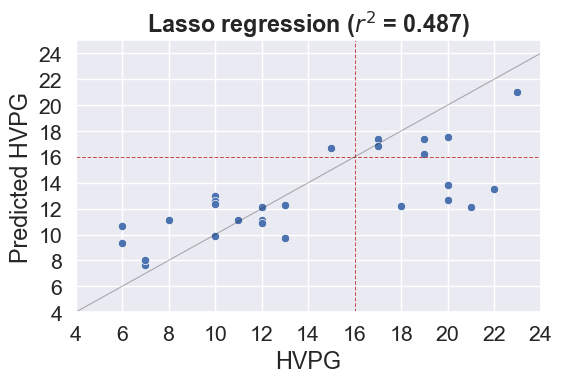

In [55]:
name = "Lasso regression"
reg = Lasso(alpha=.3).fit(X_train, y_train)

r2[name] = eval_regression(y_test, reg.predict(X_test), name)

### Support vector machine

r2 score: 0.356


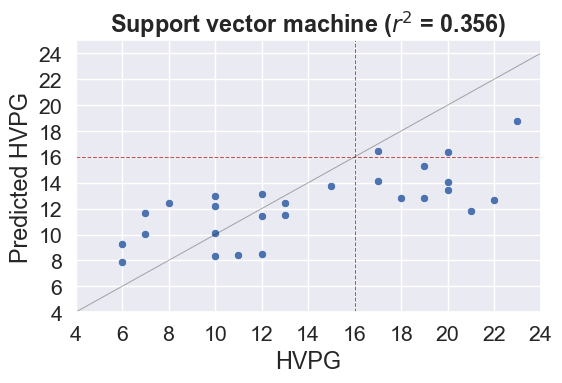

In [56]:
name = "Support vector machine"
reg = SVR(kernel='rbf', C=5).fit(X = X_train, y = y_train)

r2[name] = eval_regression(y_test, reg.predict(X_test), name)

### k-NN

r2 score: 0.330


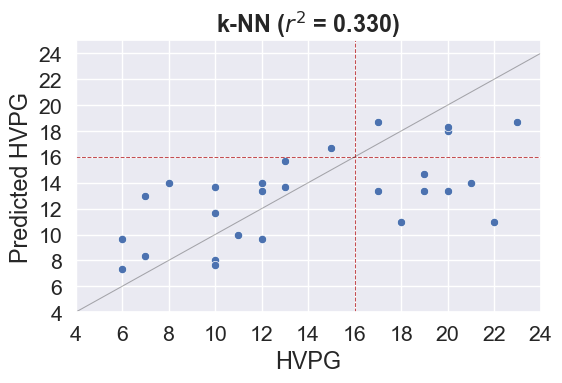

In [57]:
name = "k-NN"
reg = KNeighborsRegressor(n_neighbors=3).fit(X = X_train, y = y_train)

r2[name] = eval_regression(y_test, reg.predict(X_test), name)

### Neural network

r2 score: 0.326


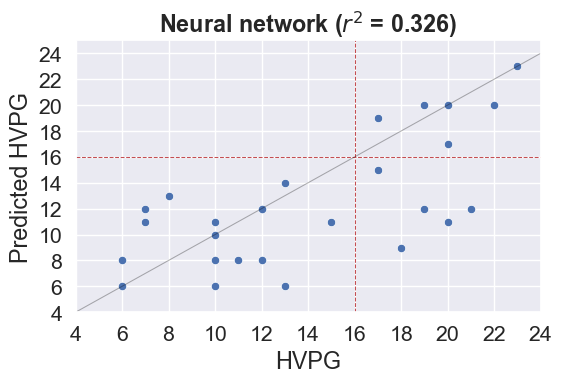

In [58]:
name = "Neural network"
reg = MLPClassifier(hidden_layer_sizes=(100), max_iter=1500, warm_start=True, alpha=1.5).fit(X_train, y_train)

r2[name] = eval_regression(y_test, reg.predict(X_test), name)

In [59]:
pd.DataFrame(sorted(list(r2.items()), key = lambda x: x[1], reverse = True), columns = ["model", "r$^2$"])

,model,r$^2$
0,Ridge regression,0.527212
1,Lasso regression,0.486988
2,Support vector machine,0.356195
3,k-NN,0.329710
4,Neural network,0.326087
5,Linear regression,-4.493313
